# Table of contents

### - Import libraries and define functions + Initial setup

### - Figure 2

### - Figure 3

### - Figure 4

### - Figure 5

### - Output novel high-confidence only annotation

# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]
    df_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [7]:
## Open original reference
original_ref = pd.read_csv("../../../references/bernardo/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

original_ref = original_ref.loc[~original_ref["chr"].str.startswith("ERCC-")]

## Parse through reference to get gene names and ids
orig_ref = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True)

## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../../../references/bernardo/medically_relevant_genes_02-04-2023_UPDATED.tsv", sep="\t")

## Brain disease genes
brain_disease_gene_ids = pd.read_csv("../../../references/bernardo/brain_disease_genes_only_IDs.tsv", sep="\t")
brain_disease_annotations = pd.read_csv("../../../references/bernardo/brain_disease_genes_with_disease.tsv", sep="\t")

## Import AD Genes
ad_names = pd.read_csv("../../../references/bernardo/AD_gwas_genes.tsv", sep="\t")

## Create disease relevant list including chromosome
disease_relevant_genes_annotated = disease_relevant_genes.merge(orig_ref[["gene_id", "gene_name", "chr"]], 
                                                               how="inner", on=["gene_id", "gene_name"])

## Create list of protein coding genes
protein_coding_ref = orig_ref.loc[orig_ref["gene_biotype"] == "protein_coding"].copy()

## Import and parse through extended annotations
ref = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

ref = parse_df_columns(ref, is_ref=False)

ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

# - Figure 2

In [8]:
## Import data for transcript level counts and fix column names

df = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df = fix_column_names(df, is_gene=False)

In [9]:
## Calculate total counts
df["total_counts"] = df[df.filter(regex='count').columns].sum(axis=1)

In [10]:
## Calculate CPM and drop count columns
df = calculate_cpm(df, is_gene=False)

df = df[df.columns.drop(list(df.filter(regex='counts')))].copy()

In [11]:
## Drop ERCCs
df = df.loc[~df["gene_id"].str.startswith("ERCC")].copy()

In [12]:
## Calculate median CPM
df["median_CPM"] = df[df.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [13]:
## Annotate transcritps in counts matrix
df = df.merge(ref_transcripts[["gene_id", "transcript_id", "chr"]], on=["gene_id", "transcript_id"], how="inner")

In [14]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
df_novel_genes = df.loc[df["gene_id"].str.startswith("BambuGene")].copy()
df_novel_transcripts = df.loc[((df["transcript_id"].str.startswith("BambuTx")) & (~df["gene_id"].str.startswith("BambuGene")))].copy()

In [15]:
## Drop new mitochondrial transcripts/genes
df_novel_genes = df_novel_genes.loc[df_novel_genes["chr"] != "MT"].copy()
df_novel_transcripts = df_novel_transcripts.loc[df_novel_transcripts["chr"] != "MT"].copy()

In [16]:
## Filter novel genes and transcripts, median CPM > 1
df_novel_genes_median = df_novel_genes[df_novel_genes["median_CPM"] > 1].copy()
df_novel_transcripts_median = df_novel_transcripts[df_novel_transcripts["median_CPM"] > 1].copy()

In [17]:
## Only keep exon entries and add size variable
ref_exons = ref.loc[ref["type"] == "exon"].copy()
ref_exons["size"] = abs(ref_exons["end"] - ref_exons["start"])

In [18]:
## Get reference for novel genes and transcripts
ref_novel_gene_median = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_genes_median["transcript_id"])].copy()
ref_novel_transcript_median = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_transcripts_median["transcript_id"])].copy()


ref_novel_gene = ref_exons.loc[ref_exons["gene_id"].str.startswith("BambuGene")].copy()
ref_novel_transcript = ref_exons.loc[((ref_exons["transcript_id"].str.startswith("BambuTx")) & 
                                      (~ref_exons["gene_id"].str.startswith("BambuGene")))].copy()

In [19]:
## get number of exons
ref_novel_gene_median_num_exons = ref_novel_gene_median["transcript_id"].value_counts()
ref_novel_transcript_median_num_exons = ref_novel_transcript_median["transcript_id"].value_counts()

ref_novel_gene_num_exons = ref_novel_gene["transcript_id"].value_counts()
ref_novel_transcript_num_exons = ref_novel_transcript["transcript_id"].value_counts()

In [20]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (55*mm, 60*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

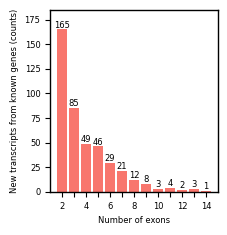

In [21]:
## Make average CPM > 1 transcript number of exons plot and save both as png and svg.

ax = sns.countplot(x=ref_novel_transcript_median_num_exons, color=ggplot2_colors[0], saturation=1)

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 185)
ax.set_xlim(-1, 13)

labels = ["2", "", "4", "", "6", "", "8", "", "10", "", "12", "", "14"]
ax.set_xticklabels(labels)

plt.xlabel("Number of exons")
plt.ylabel("New transcripts from known genes (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_2/num_exons_ntkg_median_cpm_greater_than_1.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [22]:
## Create dataframes with exonic length for each transcript
df_exonic_length_novel_genes_median = ref_novel_gene_median[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts_median = ref_novel_transcript_median[["transcript_id", "size"]].groupby('transcript_id').sum()

df_exonic_length_novel_genes = ref_novel_gene[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts = ref_novel_transcript[["transcript_id", "size"]].groupby('transcript_id').sum()

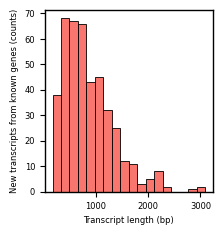

In [23]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_transcripts_median["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("New transcripts from known genes (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_2/histogram_ntkg_length_median_cpm_greater_than_one.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [24]:
## Create log transformation of median CPM for new genes and transcripts

df_novel_genes_no_zero = df_novel_genes.loc[df_novel_genes["median_CPM"] > 0].copy()
log_10_median_cpm_genes = np.log10(df_novel_genes_no_zero["median_CPM"])

df_novel_transcripts_no_zero = df_novel_transcripts.loc[df_novel_transcripts["median_CPM"] > 0].copy()
log_10_median_cpm_transcripts = np.log10(df_novel_transcripts_no_zero["median_CPM"])

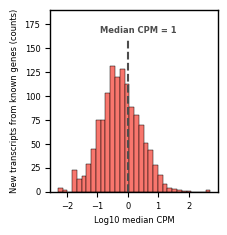

In [25]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=log_10_median_cpm_transcripts, color=ggplot2_colors[0], alpha=1)

plt.ylim(0, 190)


plt.plot([0, 0], [0, 160], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=1, linestyle='dashed')
plt.text(x=-0.9, y=166, s="Median CPM = 1",  color="#4d4d4d", fontsize=6, fontweight="bold")

plt.xlabel("Log10 median CPM")
plt.ylabel("New transcripts from known genes (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_2/median_cpm_histogram_new_transcripts.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [26]:
## Get number of transcripts

print("Number of transcripts mapping to new gene bodies (no filter):", df_novel_genes.shape[0])
print("Number of transcripts mapping to new gene bodies (median CPM > 1):", df_novel_genes_median.shape[0])

print("\n\nNumber of new transcripts mapping to annotated genes (no filter):", df_novel_transcripts.shape[0])
print("Number of new transcripts mapping to annotated genes (median CPM > 1):", df_novel_transcripts_median.shape[0])

Number of transcripts mapping to new gene bodies (no filter): 1860
Number of transcripts mapping to new gene bodies (median CPM > 1): 267


Number of new transcripts mapping to annotated genes (no filter): 1534
Number of new transcripts mapping to annotated genes (median CPM > 1): 428


In [27]:
## Get number of genes

print("Number of new genes represented (no filter):", df_novel_genes["gene_id"].nunique())
print("Number of new genes represented (median CPM > 1):", df_novel_genes_median["gene_id"].nunique())


print("\n\nNumber of represented annotated genes with new transcripts (no filter):", df_novel_transcripts["gene_id"].nunique())
print("Number of represented annotated genes with new transcripts (median CPM > 1):", df_novel_transcripts_median["gene_id"].nunique())

Number of new genes represented (no filter): 1676
Number of new genes represented (median CPM > 1): 245


Number of represented annotated genes with new transcripts (no filter): 1255
Number of represented annotated genes with new transcripts (median CPM > 1): 383


In [28]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []

list_ntkg_median = []
list_ntkg_median_prot_coding = []
list_ntkg_median_med_relevant = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    ntkg_median_cpm = df_novel_transcripts.loc[df_novel_transcripts["median_CPM"] >= cpm_thresh].copy()
    ntkg_median_cpm_num = ntkg_median_cpm.shape[0]
    ntkg_median_cpm_num_prot = ntkg_median_cpm.loc[ntkg_median_cpm["gene_id"].isin(protein_coding_ref["gene_id"])].shape[0]    
    ntkg_median_cpm_num_med = ntkg_median_cpm.loc[ntkg_median_cpm["gene_id"].isin(disease_relevant_genes_annotated["gene_id"])].shape[0]    
    
    list_cpm_thresh.append(cpm_thresh)
        
    list_ntkg_median.append(ntkg_median_cpm_num)
    list_ntkg_median_prot_coding.append(ntkg_median_cpm_num_prot)
    list_ntkg_median_med_relevant.append(ntkg_median_cpm_num_med)

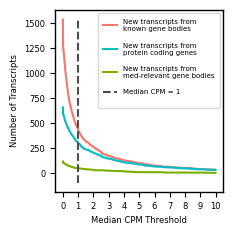

In [29]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_ntkg_median, color=ggplot2_colors[0], label="New transcripts from\nknown gene bodies", linewidth=1.5, alpha=1)
plt.plot(list_cpm_thresh, list_ntkg_median_prot_coding, color=ggplot2_colors[4], label="\nNew transcripts from\nprotein coding genes\n", linewidth=1.5, alpha=1)
plt.plot(list_cpm_thresh, list_ntkg_median_med_relevant, color=ggplot2_colors[2], label="New transcripts from\nmed-relevant gene bodies", linewidth=1.5, alpha=1)
plt.plot([1, 1], [-100, 1550], color="#4d4d4d", label="\nMedian CPM = 1\n", linewidth=1.5, alpha=1, linestyle='dashed')


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=5, borderpad=0.8)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_2/number_of_new_transcripts_across_cpm_thresh.pdf', dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [30]:
list_ntkg_median[0]

1534

In [31]:
## Import Data for new transcript events
df_events = pd.read_csv("../../../data/bernardo/processed/03.gene_and_transcripts_descriptive_stats/novel_events.tsv", sep="\t")

In [32]:
## Remove new genes
df_events = df_events.loc[df_events["txClassDescription"] != "newGene-spliced"].copy()

In [33]:
## Cleanup net transcript classes
df_events.loc[df_events["txClassDescription"] == "newWithin", "txClassDescription"] = "New combination of known exons/junctions"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newFirstExon", "txClassDescription"] = "New exon"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newLastExon", "txClassDescription"] = "New exon"
df_events.loc[df_events["txClassDescription"] == "allNew", "txClassDescription"] = "All new exons & junctions"

df_events.loc[df_events["txClassDescription"] == "newFirstJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction", "txClassDescription"] = "New junction"


df_events.loc[df_events["txClassDescription"] == "newLastJunction:newJunction:newLastExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newJunction:newFirstExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction:newFirstExon:newLastExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction:newFirstExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "New first exon & new junction", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction:newLastExon", "txClassDescription"] = "New exon & new junction"


In [34]:
## Create dataframes for the two stringency thresholds
df_events_median = df_events.loc[df_events["TXNAME"].isin(df_novel_transcripts_median["transcript_id"])]

In [35]:
## Get counts of events no filter
df_events["txClassDescription"].value_counts()

All new exons & junctions                   853
New junction                                266
New combination of known exons/junctions    197
New exon & new junction                     137
New exon                                    115
Name: txClassDescription, dtype: int64

In [36]:
## Get counts of events median CPM > 1
df_events_median["txClassDescription"].value_counts()

All new exons & junctions                   186
New junction                                 94
New combination of known exons/junctions     92
New exon & new junction                      28
New exon                                     28
Name: txClassDescription, dtype: int64

In [37]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (31.34375*mm, 34*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

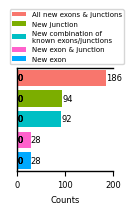

In [38]:
## Make graph of new transcript events for no filter

ax = sns.countplot(y=df_events_median["txClassDescription"], hue=df_events_median["txClassDescription"], dodge=False,
                   palette=[ggplot2_colors[0], ggplot2_colors[2], ggplot2_colors[4], ggplot2_colors[7], ggplot2_colors[5]],
                   saturation=1, order=df_events_median["txClassDescription"].value_counts().index,
                  hue_order=df_events_median["txClassDescription"].value_counts().index)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlim(0, 200)

sns.despine(ax=ax, top=False, right=True, left=False, bottom=False, offset=None, trim=False)

plt.yticks(rotation=90)
plt.tick_params(labelsize=None)

plt.legend(bbox_to_anchor=(1.15, 1.6), fontsize=5, borderpad=0.3, labels=["All new exons & junctions", "New junction", 
                                                                       "New combination of\nknown exons/junctions",
                                                                       "New exon & junction", "New exon"])
plt.xlabel('Counts')
plt.ylabel("")
plt.yticks([]) 


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_2/barplot_events_new_transcripts_median_cpm_greater_than_one.pdf',
           dpi=600, transparent=True, bbox_inches="tight")

In [39]:
## Import full length counts matrix

df_full = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/fullLengthCounts_transcript.txt", sep="\t")

In [40]:
## Get novel mitochondrial transcript ids
ref_mito_novel_ids = ref_transcripts.loc[((ref_transcripts["chr"] == "MT") & (ref_transcripts["transcript_id"].str.startswith("Bambu")))]["transcript_id"].copy()
ref_mito_novel_ids = ref_mito_novel_ids.drop_duplicates().to_list()

In [41]:
## Create counts matrix countaining only 
df_novel_mito = df_full.loc[df_full["TXNAME"].isin(ref_mito_novel_ids)].copy()

In [42]:
## Sum counts for each novel mito transcripts
df_novel_mito["median_counts"] = round(df_novel_mito[df_novel_mito.columns[2:]].median(axis=1))

In [43]:
## Only keep new mitochondrial isoforms with more than 300 full-length counts
df_novel_mito = df_novel_mito.loc[df_novel_mito["median_counts"] > 40].copy()

In [44]:
df_novel_mito

,TXNAME,GENEID,sample_579_PAG75663_mapped_filtered_sorted,sample_1131_PAM44580_mapped_filtered_sorted,sample_1218_PAM43779_mapped_filtered_sorted,sample_1304_PAM44487_mapped_filtered_sorted,sample_1271_PAM44815_mapped_filtered_sorted,sample_5356_PAM42933_mapped_filtered_sorted,sample_1163_PAM44604_mapped_filtered_sorted,sample_5295_PAG77944_mapped_filtered_sorted,sample_5292_PAG75292_mapped_filtered_sorted,sample_1092_PAM41667_mapped_filtered_sorted,sample_1186_PAM43869_mapped_filtered_sorted,sample_1291_PAG71816_mapped_filtered_sorted,median_counts
1844,BambuTx1845,ENSG00000210082,70.0,0.0,49.0,0.0,43.0,1.0,843.0,98.0,59.0,2.0,19.0,44.0,44.0
1845,BambuTx1846,ENSG00000210082,150.0,26.0,14.0,17.0,114.0,2.0,81.0,284.0,110.0,46.0,29.0,110.0,64.0
1846,BambuTx1847,ENSG00000210082,878.0,36.0,1133.0,50.0,663.0,11.0,694.0,1604.0,803.0,209.0,240.0,1020.0,678.0
1847,BambuTx1848,ENSG00000210082,352.0,13.0,910.0,31.0,641.0,41.0,736.0,2546.0,720.0,145.0,167.0,1795.0,496.0
1849,BambuTx1850,ENSG00000210107,218.0,1.0,391.0,0.0,268.0,0.0,114.0,721.0,338.0,1.0,0.0,792.0,166.0


In [45]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (55*mm, 60*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

In [46]:
## Get transcript ids for protein coding mitochondrial transcripts
orig_ref_transcript = original_ref.loc[original_ref["type"] == "transcript"].copy()
known_transcript_ref = parse_df_columns(orig_ref_transcript.copy(), is_ref=True, is_transcript=True)

ref_mito_protein_coding = known_transcript_ref.loc[known_transcript_ref["chr"] == "MT"].copy()
ref_mito_protein_coding = ref_mito_protein_coding.loc[ref_mito_protein_coding["transcript_biotype"] == "protein_coding"].copy()

mito_protein_coding_ids = ref_mito_protein_coding["transcript_id"].copy()

In [47]:
## Create counts matrix countaining only protein coding mitochondrial transcripts
df_known_mito = df_full.loc[df_full["TXNAME"].isin(mito_protein_coding_ids)].copy()

## Sum counts for each novel mito transcripts
df_known_mito["median_counts"] = round(df_known_mito[df_known_mito.columns[2:]].median(axis=1))

In [48]:
## Add gene names to known mitochondrial transcripts full length counts matrices
df_known_mito["transcript_id"] = df_known_mito["TXNAME"].copy()
df_known_mito = df_known_mito.merge(ref_mito_protein_coding[["transcript_id", "gene_name"]], on="transcript_id", how="inner")

## Make TXNAME equal to gene_name columns, then drop transcript_id and gene_id columns
df_known_mito["TXNAME"] = df_known_mito["gene_name"]
df_known_mito.drop(columns=["gene_name", "transcript_id"], inplace=True)

In [49]:
## Concatenate new and novel mitochondrial full length reads
df_full_mito = pd.concat([df_known_mito, df_novel_mito])

In [50]:
## Only keep relevant columns
df_full_mito = df_full_mito[["TXNAME", "GENEID", "median_counts"]].copy()

In [51]:
## Log10 transformation
df_full_mito["log10_median_counts"] = round(np.log10(df_full_mito["median_counts"]), 2)

## Replace BambuTx with just Tx (better to graph)
df_full_mito["TXNAME"] = df_full_mito["TXNAME"].str.replace("Bambu", "")

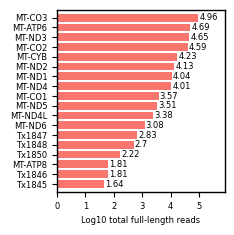

In [52]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)
ax = sns.barplot(data=df_full_mito, x="log10_median_counts", y="TXNAME",
            color=ggplot2_colors[0], saturation=1, 
                 order=df_full_mito.sort_values(by="log10_median_counts", ascending=False)["TXNAME"])

ax.bar_label(ax.containers[0], fontsize=6, padding=0.8)
plt.ylabel("")
plt.xlabel("Log10 total full-length reads", fontsize=6)
plt.yticks(fontsize=6)

ax.set_ylim(17.8, -0.8)
ax.set_xlim(0, 5.9)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_2/novel_transcripts_median_full_length_counts.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [53]:
## Load reference to make mitochondrial reference and plot it on USCS genome browser
ref_mito_out = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


In [54]:
## Only keep novel mitochondrial transcripts

ref_mito_out = ref_mito_out.loc[ref_mito_out["chr"] == "MT"].copy()
ref_mito_out["transcript_id"] = ref_mito_out["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
ref_mito_out = ref_mito_out.loc[ref_mito_out["transcript_id"].isin(df_novel_mito["TXNAME"])].copy()
ref_mito_out.drop(columns="transcript_id", inplace=True)
ref_mito_out["other"] = ref_mito_out["other"].str.replace("BambuTx", "Tx")
ref_mito_out["chr"] = "chrM"

In [55]:
## Save mitochondrial reference for plotting on USCS tracks
ref_mito_out.to_csv("../../../data/bernardo/processed/03.gene_and_transcripts_descriptive_stats/mito_annotation_for_figure.gtf",
                   sep="\t", index=False, header=False, quoting=csv.QUOTE_NONE)

In [84]:
## Create percentages containing motiffs for MEME figures

### 3 PRIME NFN ###

nfn_3_prime_in = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_nfn_12s.fa", 'r')
Lines_in = nfn_3_prime_in.readlines()


nfn_3_prime_out = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_nfn_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][10:12] == "AG"):
        nfn_3_prime_out.write(Lines_in[i-1])
        nfn_3_prime_out.write(Lines_in[i])
        
nfn_3_prime_out.close()

nfn_3_prime_out = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_nfn_12s_VALIDATED.fa", 'r')
Lines_out = nfn_3_prime_out.readlines()

percent_3_nfn = round((len(Lines_out)/len(Lines_in)) * 100, 1)

nfn_3_prime_out.close()

In [85]:
print(len(Lines_in))

538


In [86]:
### 5 PRIME NFN ###

nfn_5_prime_in = open("../../../data/bernardo/processed/MEME/five_prime_splice_sites_nfn_12s.fa", 'r')
Lines_in = nfn_5_prime_in.readlines()

nfn_5_prime_out = open("../../../data/bernardo/processed/MEME/five_prime_splice_sites_nfn_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to filesf
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][3:5] == "GT"):
        nfn_5_prime_out.write(Lines_in[i-1])
        nfn_5_prime_out.write(Lines_in[i])
        
nfn_5_prime_out.close()

nfn_5_prime_out = open("../../../data/bernardo/processed/MEME/five_prime_splice_sites_nfn_12s_VALIDATED.fa", 'r')
Lines_out = nfn_5_prime_out.readlines()

percent_5_nfn = round((len(Lines_out)/len(Lines_in)) * 100, 1)

nfn_5_prime_out.close()

In [87]:
print(len(Lines_in))

538


In [88]:
## Create percentages containing motiffs for MEME figures

### 3 PRIME NFK ###

nfk_3_prime_in = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_nfk_12s.fa", 'r')
Lines_in = nfk_3_prime_in.readlines()


nfk_3_prime_out = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_nfk_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][10:12] == "AG"):
        nfk_3_prime_out.write(Lines_in[i-1])
        nfk_3_prime_out.write(Lines_in[i])
        
nfk_3_prime_out.close()

nfk_3_prime_out = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_nfk_12s_VALIDATED.fa", 'r')
Lines_out = nfk_3_prime_out.readlines()

percent_3_nfk = round((len(Lines_out)/len(Lines_in)) * 100, 1)

nfk_3_prime_out.close()

In [89]:
print(len(Lines_in))

734


In [90]:
### 5 PRIME NFK ###

nfk_5_prime_in = open("../../../data/bernardo/processed/MEME/five_prime_splice_sites_nfk_12s.fa", 'r')
Lines_in = nfk_5_prime_in.readlines()

nfk_5_prime_out = open("../../../data/bernardo/processed/MEME/five_prime_splice_sites_nfk_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][3:5] == "GT"):
        nfk_5_prime_out.write(Lines_in[i-1])
        nfk_5_prime_out.write(Lines_in[i])
        
nfk_5_prime_out.close()

nfk_5_prime_out = open("../../../data/bernardo/processed/MEME/five_prime_splice_sites_nfk_12s_VALIDATED.fa", 'r')
Lines_out = nfk_5_prime_out.readlines()

percent_5_nfk = round((len(Lines_out)/len(Lines_in)) * 100, 1)

nfk_5_prime_out.close()

In [91]:
print(len(Lines_in))

750


In [92]:
## Create percentages containing motiffs for MEME figures

### 3 PRIME kfk ###

kfk_3_prime_in = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_kfk_12s.fa", 'r')
Lines_in = kfk_3_prime_in.readlines()


kfk_3_prime_out = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_kfk_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][10:12] == "AG"):
        kfk_3_prime_out.write(Lines_in[i-1])
        kfk_3_prime_out.write(Lines_in[i])
        
kfk_3_prime_out.close()

kfk_3_prime_out = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_kfk_12s_VALIDATED.fa", 'r')
Lines_out = kfk_3_prime_out.readlines()

percent_3_kfk = round((len(Lines_out)/len(Lines_in)) * 100, 1)

kfk_3_prime_out.close()

In [93]:
print(len(Lines_in))

303880


In [94]:
### 5 PRIME KFK ###

kfk_5_prime_in = open("../../../data/bernardo/processed/MEME/five_prime_splice_sites_kfk_12s.fa", 'r')
Lines_in = kfk_5_prime_in.readlines()

kfk_5_prime_out = open("../../../data/bernardo/processed/MEME/five_prime_splice_sites_kfk_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][3:5] == "GT"):
        kfk_5_prime_out.write(Lines_in[i-1])
        kfk_5_prime_out.write(Lines_in[i])
        
kfk_5_prime_out.close()

kfk_5_prime_out = open("../../../data/bernardo/processed/MEME/five_prime_splice_sites_kfk_12s_VALIDATED.fa", 'r')
Lines_out = kfk_5_prime_out.readlines()

percent_5_kfk = round((len(Lines_out)/len(Lines_in)) * 100, 1)

kfk_5_prime_out.close()

In [95]:
print(len(Lines_in))

305778


In [96]:
### 3 PRIME NFM ###

nfm_3_prime_in = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_nfm_12s.fa", 'r')
Lines_in = nfm_3_prime_in.readlines()


nfm_3_prime_out = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_nfm_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][10:12] == "AG"):
        nfm_3_prime_out.write(Lines_in[i-1])
        nfm_3_prime_out.write(Lines_in[i])
        
nfm_3_prime_out.close()

nfm_3_prime_out = open("../../../data/bernardo/processed/MEME/three_prime_splice_sites_nfm_12s_VALIDATED.fa", 'r')
Lines_out = nfm_3_prime_out.readlines()

percent_3_nfm = round((len(Lines_out)/len(Lines_in)) * 100, 1)

nfm_3_prime_out.close()

In [97]:
print(len(Lines_in))

10


In [98]:
### 5 PRIME NFM ###

nfm_5_prime_in = open("../../../data/bernardo/processed/MEME/five_prime_splice_sites_nfm_12s.fa", 'r')
Lines_in = nfm_5_prime_in.readlines()

nfm_5_prime_out = open("../../../data/bernardo/processed/MEME/five_prime_splice_site_nfm_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):
    
    if (Lines_in[i][3:5] == "GT"):
        nfm_5_prime_out.write(Lines_in[i-1])
        nfm_5_prime_out.write(Lines_in[i])
        
nfm_5_prime_out.close()

nfm_5_prime_out = open("../../../data/bernardo/processed/MEME/five_prime_splice_site_nfm_12s_VALIDATED.fa", 'r')
Lines_out = nfm_5_prime_out.readlines()

percent_5_nfm = round((len(Lines_out)/len(Lines_in)) * 100, 1)

nfm_5_prime_out.close()

In [99]:
print(len(Lines_in))

10


In [100]:
five_prime_kfk = percent_5_kfk
three_prime_kfk = percent_3_kfk

five_prime_nfk = percent_5_nfk
three_prime_nfk = percent_3_nfk

five_prime_nfn = percent_5_nfn
three_prime_nfn = percent_3_nfn

five_prime_nfm = percent_5_nfm
three_prime_nfm = percent_3_nfm

In [101]:
print(five_prime_kfk)
print(three_prime_kfk)
print(five_prime_nfk)
print(three_prime_nfk)
print(five_prime_nfn)
print(three_prime_nfn)
print(five_prime_nfm)
print(three_prime_nfm)

98.9
99.8
94.9
100.0
82.5
90.7
60.0
100.0


In [102]:
dict_nfk = {"Percent exons containing motiff": [five_prime_nfk, five_prime_kfk, three_prime_nfk, three_prime_kfk], 
            "Splice site motiff": ["Five prime splice site motiff", "Five prime splice site motiff", "Three prime splice site motiff", "Three prime splice site motiff"],
           "Category": ["New transcripts for\nknown gene body", "Annotated transcripts", "New transcripts for\nknown gene body", "Annotated transcripts"]}

df_nfk = pd.DataFrame(dict_nfk)



dict_nfn = {"Percent exons containing motiff": [five_prime_nfn, five_prime_kfk, three_prime_nfn, three_prime_kfk], 
            "Splice site motiff": ["Five prime splice site motiff", "Five prime splice site motiff", "Three prime splice site motiff", "Three prime splice site motiff"],
           "Category": ["New transcripts for\nnew gene body", "Annotated transcripts", "New transcripts for\nnew gene body", "Annotated transcripts"]}

df_nfn = pd.DataFrame(dict_nfn)



dict_nfm = {"Percent exons containing motiff": [five_prime_nfm, five_prime_kfk, three_prime_nfm, three_prime_kfk], 
            "Splice site motiff": ["Five prime splice site motiff", "Five prime splice site motiff", "Three prime splice site motiff", "Three prime splice site motiff"],
           "Category": ["New mitochondrial transcript", "Annotated transcripts", "New mitochondrial transcript", "Annotated transcripts"]}

df_nfm = pd.DataFrame(dict_nfm)

/tmp/ipykernel_3854003/3625668849.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 50, 100], ylabel="")


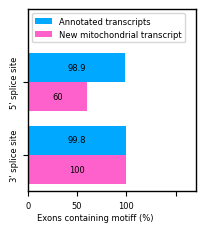

In [105]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

df_nfm.sort_values(by="Splice site motiff", ascending=False, inplace=True)

ax = sns.barplot(data=df_nfm, x="Percent exons containing motiff", y="Splice site motiff", hue="Category",
                 palette=[ggplot2_colors[7], ggplot2_colors[5]], errorbar=None, saturation=1)

for container in ax.containers:
    ax.bar_label(container, label_type="center")
    
    
ax.set(xlim=(0, 170), ylim=(-0.5, 2))
plt.xlabel('Exons containing motiff (%)')
ax.xaxis.set_label_coords(0.4, -0.12)

ax.set(xticklabels=[0, 50, 100], ylabel="")
ax.set_yticklabels(labels=["3' splice site\n", "5' splice site\n"], rotation=90, ha="center", rotation_mode="anchor")

# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
order = [1, 0]
  
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left')
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_2/mito_MEME.pdf', 
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

/tmp/ipykernel_3854003/2603506306.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 50, 100], ylabel="")


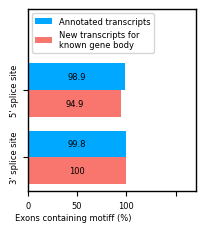

In [106]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

df_nfk.sort_values(by="Splice site motiff", ascending=False, inplace=True)


ax = sns.barplot(data=df_nfk, x="Percent exons containing motiff", y="Splice site motiff", hue="Category",
                 palette=[ggplot2_colors[0], ggplot2_colors[5]], errorbar=None, saturation=1)

for container in ax.containers:
    ax.bar_label(container, label_type="center")
    
    
ax.set(xlim=(0, 170), ylim=(-0.5, 2.2))
plt.xlabel('Exons containing motiff (%)')
ax.xaxis.set_label_coords(0.27, -0.12)

ax.set(xticklabels=[0, 50, 100], ylabel="")
ax.set_yticklabels(labels=["3' splice site\n", "5' splice site\n"], rotation=90, ha="center", rotation_mode="anchor")

# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
order = [1, 0]
  
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left')


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_2/new_from_known_MEME.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

# Figure 3

In [66]:
disease_relevant_genes_annotated.shape

(5035, 3)

In [67]:
## Create list o disease relevant novel transcripts with median  CPM > 1
novel_relevant_median = df_novel_transcripts_median.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

In [68]:
## Drop any duplicates
novel_relevant_median.drop_duplicates(inplace=True)

In [69]:
## Get all transcript from the same gene as the new transcripts so we can calculate relative abundance of 
## New transcripts in each gene
novel_relevant_median_counts = pd.merge(df, novel_relevant_median[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [70]:
## Calculate relative transcript abundance
novel_relevant_median_relative_abundance = relative_transcript_abundance(novel_relevant_median_counts)

In [71]:
## Annotate novel transcripts on relative abundance table
novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_median_relative_abundance.loc[~novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

In [72]:
## Create list with med relevant genes with novel isoforms and their relative frequency
novel_relevant_median_words = novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

In [73]:
## Drop duplicates
novel_relevant_median_words = novel_relevant_median_words.drop_duplicates()

In [74]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
novel_relevant_median_words = round(novel_relevant_median_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [75]:
## Create a dataframe to properly store the data
novel_relevant_median_words_df = pd.DataFrame()
novel_relevant_median_words_df['word_count'] = novel_relevant_median_words
novel_relevant_median_words_df["gene_name"] = novel_relevant_median_words.index

In [76]:
## Drop index
novel_relevant_median_words_df.reset_index(inplace=True, drop=True)

In [77]:
## Print number of disease relevant genes with high-confidence novel isoforms
print("Number of medically relevant genes with novel transcripts (median CPM > 1):", novel_relevant_median_words_df["gene_name"].nunique())

Number of medically relevant genes with novel transcripts (median CPM > 1): 49


In [78]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant median CPM > 1

word_list_disease_median = ""

for i in range(len(novel_relevant_median_words_df)):
        
    for j in range(int(novel_relevant_median_words_df.iloc[i][0])):
        word_list_disease_median = word_list_disease_median + novel_relevant_median_words_df.iloc[i][1] + " "

In [79]:
## Create GGPLOT2 colormap for the wordcloud (THANKS MARK!)

from matplotlib.colors import LinearSegmentedColormap

ggplot2_colormap = LinearSegmentedColormap.from_list(
        "ggplot_2", ggplot2_colors, N=8)

In [80]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (225*mm, 225*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

In [81]:
## Generate wordclouds
word_cloud_disease_median = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=6400, height=2000).generate(word_list_disease_median)

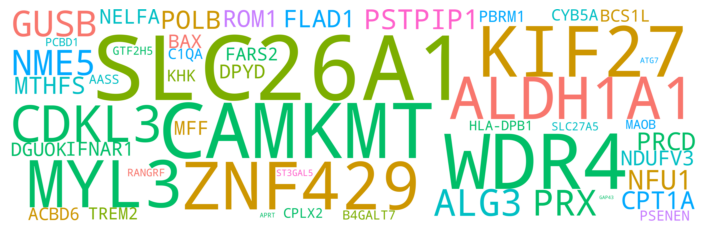

In [82]:
## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_disease_median, interpolation='bilinear', alpha=1)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_3/word_cloud_disease_median.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [83]:
novel_relevant_median_words_df

,word_count,gene_name
0,9.0,AASS
1,17.0,ACBD6
2,40.0,ALDH1A1
3,39.0,ALG3
4,2.0,APRT
5,3.0,ATG7
6,9.0,B4GALT7
7,19.0,BAX
8,16.0,BCS1L
9,12.0,C1QA


# Figure 4

In [84]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (55*mm, 60*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

In [85]:
## Get number of transcripts from each filter from each filter
print("Number of transcripts mapping to new gene bodies (median CPM > 1):", df_novel_genes_median.shape[0])
print("Number of new transcripts mapping to annotated genes (median CPM > 1):", df_novel_transcripts_median.shape[0])

Number of transcripts mapping to new gene bodies (median CPM > 1): 267
Number of new transcripts mapping to annotated genes (median CPM > 1): 428


In [86]:
## Get number of genes represented for each filter

print("Number of new genes represented (median CPM > 1):", df_novel_genes_median["gene_id"].nunique())

print("Number of represented annotated genes with new transcripts (median CPM > 1):", df_novel_transcripts_median["gene_id"].nunique())

Number of new genes represented (median CPM > 1): 245
Number of represented annotated genes with new transcripts (median CPM > 1): 383


In [87]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []

list_ntng_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    ntng_median_cpm = df_novel_genes.loc[df_novel_genes["median_CPM"] >= cpm_thresh].copy()
    ntng_median_cpm_num = ntng_median_cpm.shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
        
    list_ntng_median.append(ntng_median_cpm_num)

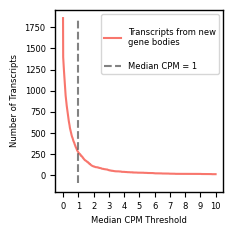

In [88]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_ntng_median, color=ggplot2_colors[0], label="Transcripts from new gene bodies", linewidth=1.5, alpha=1)
plt.plot([1, 1], [-100, 1850], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=0.7, linestyle='dashed')

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right",labels=["\nTranscripts from new\ngene bodies\n", "Median CPM = 1"])

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/new_gene_bodies_across_CPM_threshold.pdf', dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [89]:
list_ntng_median[0]

1860

In [90]:
## Cleanup annotations
novel_genes_ref = ref.loc[ref["gene_id"].str.startswith("BambuGene")].copy()
novel_genes_ref = novel_genes_ref.loc[novel_genes_ref["type"] == "transcript"].copy()
novel_genes_ref["gene_name"] = np.nan

novel_genes_ref.drop(columns="exon_number", inplace=True)

In [91]:
## Find events for new genes (overlapping without exon overlap in same strand, opposite strand overlap, no overlap)

df_overlapping_novel_genes_same = pd.DataFrame(columns=['gene_id', 'gene_name', 'chr', 'source', 'type', 'start', 
                                               'end', 'strand', "overlapping", "category"])

df_overlapping_novel_genes_opp = pd.DataFrame(columns=['gene_id', 'gene_name', 'chr', 'source', 'type', 'start', 
                                               'end', 'strand', "overlapping", "category"])

for index in novel_genes_ref.index:
    
    df_transcript = novel_genes_ref.loc[novel_genes_ref.index == index].copy()
    
    transcript_id = df_transcript["transcript_id"].iloc[0]
    
    df_transcript = df_transcript[['gene_id', 'gene_name', 'chr', 'source', 'type', 'start', 'end', 'strand']].copy()
    
    start = df_transcript["start"].iloc[0]
    end = df_transcript["end"].iloc[0]
    chrom = df_transcript["chr"].iloc[0]
    strand = df_transcript["strand"].iloc[0]
    
    df_overlapping_genes_opp = orig_ref.loc[((orig_ref["chr"] == chrom) & ((start < orig_ref["end"]) &  (end > orig_ref["start"])) & (strand != orig_ref["strand"]))]
    df_overlapping_genes_same = orig_ref.loc[((orig_ref["chr"] == chrom) & ((start < orig_ref["end"]) &  (end > orig_ref["start"])) & (strand == orig_ref["strand"]))]
    
    if df_overlapping_genes_opp.shape[0] > 0:
    
        df_overlapping_genes_opp = df_overlapping_genes_opp[['gene_id', 'gene_name', 'chr', 'source', 'type', 'start', 
                                                   'end', 'strand']].copy()

        df_overlapping_genes_opp["overlapping"] = transcript_id
        df_transcript["overlapping"] = transcript_id
        df_overlapping_genes_opp["category"] = "overlapping_gene"
        df_transcript["category"] = "new_gene_body"

        df_overlapping_novel_genes_opp = pd.concat([df_overlapping_novel_genes_opp, df_overlapping_genes_opp])
        
    elif df_overlapping_genes_same.shape[0] > 0:
        
        df_overlapping_genes_same = df_overlapping_genes_same[['gene_id', 'gene_name', 'chr', 'source', 'type', 'start', 
                                           'end', 'strand']].copy()

        df_overlapping_genes_same["overlapping"] = transcript_id
        df_transcript["overlapping"] = transcript_id
        df_overlapping_genes_same["category"] = "overlapping_gene"
        df_transcript["category"] = "new_gene_body"

        df_overlapping_novel_genes_same = pd.concat([df_overlapping_novel_genes_same, df_overlapping_genes_same])

In [92]:
## Create list of overlapping genes

all_overlapping_id_list = []

all_overlapping_id_list += df_overlapping_novel_genes_opp["overlapping"].unique().tolist()
all_overlapping_id_list += df_overlapping_novel_genes_same["overlapping"].unique().tolist()

In [93]:
## Create list of non-overlapping genes
non_overlapping_new_genes = novel_genes_ref.loc[~novel_genes_ref["transcript_id"].isin(all_overlapping_id_list)].copy()

In [94]:
## Get transcript ids for all transcripts with median CPM > 1
new_gene_tids_median = df_novel_genes_median["transcript_id"].tolist()

In [95]:
## Create individual dataframe for each subcategory, only keeping transcripts with median CPM > 1
df_overlapping_novel_genes_opp_median = df_overlapping_novel_genes_opp.loc[df_overlapping_novel_genes_opp["overlapping"].isin(new_gene_tids_median)].copy()
df_overlapping_novel_genes_same_median = df_overlapping_novel_genes_same.loc[df_overlapping_novel_genes_same["overlapping"].isin(new_gene_tids_median)].copy()
non_overlapping_new_genes_median = non_overlapping_new_genes.loc[non_overlapping_new_genes["transcript_id"].isin(new_gene_tids_median)].copy()

In [96]:
## Create final dataframe for plotting

list_number_of_transcripts = [non_overlapping_new_genes_median["transcript_id"].nunique(),
                              df_overlapping_novel_genes_opp_median["overlapping"].nunique(),
                             df_overlapping_novel_genes_same_median["overlapping"].nunique()]


list_categories = ["Not overlapping any gene bodies",
                  "Overlapping gene body on opposite strand",
                  "Overlapping gene body on same strand, but no exon overlap"]

dict_new_genes = {"Count": list_number_of_transcripts, "Category": list_categories}

df_new_genes_counts_median = pd.DataFrame(data=dict_new_genes)

In [97]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (31.34375*mm, 34*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

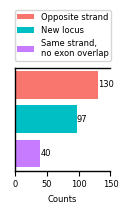

In [98]:
## Make graph of new transcript events for no filter

ax = sns.barplot(data=df_new_genes_counts_median, y="Category", hue="Category", x="Count", dodge=False,
                   palette=[ggplot2_colors[0], ggplot2_colors[4], ggplot2_colors[6]],
                   saturation=1, order=df_new_genes_counts_median.sort_values(by="Count", ascending=False)["Category"],
                hue_order=df_new_genes_counts_median.sort_values(by="Count", ascending=False)["Category"])

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlim(0, 150)

sns.despine(ax=ax, top=False, right=True, left=False, bottom=False, offset=None, trim=False)

plt.yticks(rotation=90)
plt.tick_params(labelsize=None)

new_labels = ['Opposite strand', 'New locus',
             "Same strand,\nno exon overlap"]
plt.legend(fontsize=6, bbox_to_anchor=(1.05, 1.6), borderpad=0.3)
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)
    
plt.xlabel('Counts')
plt.ylabel("")
plt.yticks([]) 

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/new_gene_body_events.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [99]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (55*mm, 60*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

/tmp/ipykernel_3854003/394514020.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 50, 100], ylabel="")


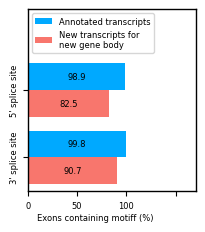

In [107]:
## Create and save graph showing number of genes with multiple protein coding isoforms (median CPM > 1)

df_nfn.sort_values(by="Splice site motiff", ascending=False, inplace=True)

ax = sns.barplot(data=df_nfn, x="Percent exons containing motiff", y="Splice site motiff", hue="Category",
                 palette=[ggplot2_colors[0], ggplot2_colors[5]], errorbar=None, saturation=1)

for container in ax.containers:
    ax.bar_label(container, label_type="center")
    
    
ax.set(xlim=(0, 170), ylim=(-0.5, 2.2))
plt.xlabel('Exons containing motiff (%)')
ax.xaxis.set_label_coords(0.4, -0.12)

ax.set(xticklabels=[0, 50, 100], ylabel="")
ax.set_yticklabels(labels=["3' splice site\n", "5' splice site\n"], rotation=90, ha="center", rotation_mode="anchor")

# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
order = [1, 0]
  
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left')

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/MEME.pdf', dpi=600, transparent=True, bbox_inches="tight")

plt.show()

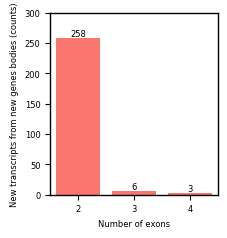

In [101]:
## Make median CPM > 1 gene body number of exons plot and save both as pdf.

ax = sns.countplot(x=ref_novel_gene_median_num_exons, color=ggplot2_colors[0], saturation=1)
    
for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 300)

plt.xlabel("Number of exons")
plt.ylabel("New transcripts from new genes bodies (counts)")


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/num_exons_ntng_median_cpm_greater_than_1.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [102]:
df_exonic_length_novel_genes_median["size"].describe()

count     267.000000
mean     1663.580524
std      1203.156858
min       109.000000
25%       545.500000
50%      1529.000000
75%      2540.000000
max      5291.000000
Name: size, dtype: float64

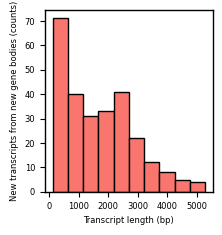

In [103]:
## Make median CPM > 1 gene body number of exons plot and save as pdf.

sns.histplot(x=df_exonic_length_novel_genes_median["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("New transcripts from new gene bodies (counts)")


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/histogram_ntng_length_median_cpm_greater_than_one.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [104]:
## Create log transformation of median CPM for new genes and transcripts

df_novel_genes_no_zero = df_novel_genes.loc[df_novel_genes["median_CPM"] > 0].copy()
log_10_median_cpm_genes = np.log10(df_novel_genes_no_zero["median_CPM"])

df_novel_transcripts_no_zero = df_novel_transcripts.loc[df_novel_transcripts["median_CPM"] > 0].copy()
log_10_median_cpm_transcripts = np.log10(df_novel_transcripts_no_zero["median_CPM"])

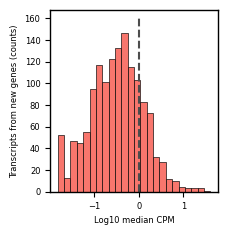

In [105]:
## Make median CPM > 1 gene body number of exons plot and save as pdf.

sns.histplot(x=log_10_median_cpm_genes, color=ggplot2_colors[0], alpha=1)

plt.plot([0, 0], [0, 160], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=1, linestyle='dashed')

plt.xlabel("Log10 median CPM")
plt.ylabel("Transcripts from new genes (counts)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_4/median_cpm_histogram_new_genes.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

# Figure 5

In [106]:
## Parse through original GTF 107 Ensembl reference to get transcript biotypes
orig_ref_types = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_ref_types = parse_df_columns(orig_ref_types, is_ref=True, is_transcript=True)

In [107]:
## Make reference only including protein coding transcripts with a defined CDS
orig_ref_cds = original_ref.loc[original_ref["type"]=="CDS"].copy()
orig_ref_cds = parse_df_columns(orig_ref_cds, is_ref=True, is_transcript=True, is_prot=True)

orig_ref_cds = orig_ref_cds.loc[orig_ref_cds["transcript_biotype"] == "protein_coding"].copy()

In [108]:
## Create unique identifier for protein id
unique_protein_id = pd.DataFrame()
string_orig_ref_cds = orig_ref_cds[['protein_id', 'start', 'end']].copy().astype(str)

unique_protein_id = string_orig_ref_cds.groupby(['protein_id'])[["protein_id", "start", "end"]].transform(lambda x: '-'.join(x))

unique_protein_id["protein_id"] = unique_protein_id["protein_id"].str.split("-", expand=True)[0]
unique_protein_id["unique_identifier"] = "Start coordinates: " + unique_protein_id["start"].copy() + "   End coordinates:" + unique_protein_id["end"].copy()
unique_protein_id = unique_protein_id[["protein_id", "unique_identifier"]].copy()
unique_protein_id.drop_duplicates(inplace=True)
unique_protein_id = unique_protein_id.merge(orig_ref_cds["transcript_id"], left_index=True, right_index=True)

orig_ref_cds = orig_ref_cds.merge(unique_protein_id, on=["protein_id", "transcript_id"], how="inner")
orig_ref_cds["protein_id"] = orig_ref_cds["unique_identifier"].copy()
orig_ref_cds.drop(columns="unique_identifier", inplace=True)

In [109]:
## Only keep protein coding

ref_cds = orig_ref_cds.loc[~orig_ref_cds["protein_id"].isna()].copy()

ref_cds = ref_cds[["transcript_id", "protein_id"]].copy().drop_duplicates()

In [110]:
## Create dataframes for AD and med relevant genes, drop Mitochondria
df_med_relevant = df.merge(disease_relevant_genes, on="gene_id", how="inner")
df_med_relevant = df_med_relevant.loc[df_med_relevant["chr"] != "MT"].copy()

df_brain_relevant = df_med_relevant.merge(brain_disease_gene_ids["gene_id"], on="gene_id", how="inner")

df_ad = df.merge(ad_names, on="gene_id", how="inner")
df_ad = df_ad.loc[df_ad["chr"] != "MT"].copy()

In [111]:
## Only keep protein coding transcripts in expression matrix, adding protein_ids
df_prot_coding_ccds = df.merge(ref_cds[["transcript_id", "protein_id"]],
                                  how="inner", on="transcript_id").drop_duplicates()

In [112]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_genes_all_median = []
list_genes_proteins_median = []
list_genes_med_relevant_median = []
list_genes_med_relevant_proteins_median = []
list_brain_relevant_median = []
list_brain_relevant_proteins_median = []
list_genes_ad_median = []
list_genes_ad_proteins_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    df_gene_multiple_all = df.loc[df["median_CPM"] >= cpm_thresh].copy()
    df_gene_multiple_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] >= cpm_thresh].copy()

    
    df_gene_multiple_prot = df_gene_multiple_prot.loc[~df_gene_multiple_prot.duplicated(subset=["protein_id"], keep=False)].copy()
    df_gene_multiple_prot = df_gene_multiple_prot.loc[df_gene_multiple_prot.duplicated(subset=["gene_id"], keep=False)].copy()

    
    num_genes_multiple_isoforms = df_gene_multiple_all.loc[df_gene_multiple_all.duplicated(subset="gene_id", keep=False)]["gene_id"].nunique()
    num_genes_multiple_prot = df_gene_multiple_prot["gene_id"].nunique()

    list_cpm_thresh.append(cpm_thresh)
    
    list_genes_all_median.append(num_genes_multiple_isoforms)
    list_genes_proteins_median.append(num_genes_multiple_prot)

In [113]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (55*mm, 46*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

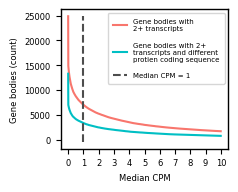

In [114]:
## Make plot showing number of different CDS transcripts from genes expressing 2+ Transcripts with a different CDS

plt.plot(list_cpm_thresh, list_genes_all_median, color=ggplot2_colors[0], label="Gene bodies with\n2+ transcripts", linewidth=1.5, alpha=1)
plt.plot(list_cpm_thresh, list_genes_proteins_median, color=ggplot2_colors[4], label="\nGene bodies with 2+\ntranscripts and different\nprotien coding sequence\n", linewidth=1.5, alpha=1)

plt.plot([1, 1], [-500, 25000], color="#4d4d4d", label="Median CPM = 1", linewidth=1.5, alpha=1, linestyle='dashed')


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM')
plt.ylabel('Gene bodies (count)')
plt.legend(loc="upper right", borderpad=0.8, fontsize=5)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/number_of_genes_with_multiple_transcripts_across_cpm_threshold.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [115]:
## Create CPM 1 Threhold multiple isoform filter
df_multiple_iso = df.loc[df["median_CPM"] > 1].copy()
df_multiple_iso = df_multiple_iso.loc[df_multiple_iso.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_num_isoforms = df_multiple_iso["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_multiple_iso = pd.DataFrame()
df_num_multiple_iso["Number of gene bodies"] = df_num_isoforms.value_counts()
df_num_multiple_iso["Number of transcripts"] = df_num_isoforms.value_counts().index
df_num_multiple_iso["Category"] = "All transcripts"

## Group 7+ transcripts
df_num_isoforms_six = df_num_multiple_iso.loc[df_num_multiple_iso["Number of transcripts"] >= 6].copy()
df_num_isoforms_six = df_num_isoforms_six.groupby("Category").sum()
df_num_isoforms_six["Number of transcripts"] = "6+"
df_num_isoforms_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_multiple_iso = df_num_multiple_iso.loc[df_num_multiple_iso["Number of transcripts"] < 6].copy()
df_num_multiple_iso["Number of transcripts"] = df_num_multiple_iso["Number of transcripts"].astype(str)
df_num_multiple_iso = pd.concat([df_num_multiple_iso, df_num_isoforms_six])

In [116]:
## Create CPM 1 Threhold multiple isoform filter
df_prot_avg_multiple_iso = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] > 1].copy()
df_gene_mutiple_prot = df_prot_avg_multiple_iso.loc[~df_prot_avg_multiple_iso.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_prot = df_gene_mutiple_prot.loc[df_gene_mutiple_prot.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_prot_multiple_isoforms_median = df_gene_mutiple_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_avg = pd.DataFrame()
df_num_isoforms_prot_avg["Number of gene bodies"] = df_numbers_prot_multiple_isoforms_median.value_counts()
df_num_isoforms_prot_avg["Number of transcripts"] = df_numbers_prot_multiple_isoforms_median.value_counts().index
df_num_isoforms_prot_avg["Category"] = "Transcripts with different protein coding sequence"

## Group 7+ transcripts
df_num_isoforms_prot_six = df_num_isoforms_prot_avg.loc[df_num_isoforms_prot_avg["Number of transcripts"] >= 6].copy()
df_num_isoforms_prot_six = df_num_isoforms_prot_six.groupby("Category").sum()
df_num_isoforms_prot_six["Number of transcripts"] = "6+"
df_num_isoforms_prot_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_prot_avg = df_num_isoforms_prot_avg.loc[df_num_isoforms_prot_avg["Number of transcripts"] < 6].copy()
df_num_isoforms_prot_avg["Number of transcripts"] = df_num_isoforms_prot_avg["Number of transcripts"].astype(str)
df_num_isoforms_prot_avg = pd.concat([df_num_isoforms_prot_avg, df_num_isoforms_prot_six])

In [117]:
## Concatenate
df_number_isoforms_per_gene = pd.concat([df_num_multiple_iso, df_num_isoforms_prot_avg])

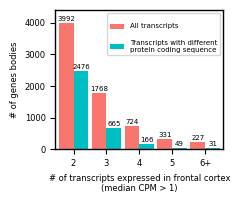

In [118]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_number_isoforms_per_gene, y="Number of gene bodies", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1, dodge=True, width=0.9)


labels = ["\nAll transcripts\n", "Transcripts with different\nprotein coding sequence"]
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, fontsize=5)

ax.set(ylim=(0, 4400), xlim=(-0.55, 4.55))
plt.ylabel("# of genes bodies")
plt.xlabel("# of transcripts expressed in frontal cortex\n(median CPM > 1)")

ax.bar_label(ax.containers[0], fontsize=5, padding=1)
ax.bar_label(ax.containers[1], fontsize=5, padding=1)    

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/number_of_genes_with_multiple_transcripts_cpm_1.pdf', 
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [119]:
## Create CPM 1 Threhold multiple isoform filter
df_gene_mutiple_med = df_med_relevant.loc[df_med_relevant["median_CPM"] > 1].copy()
df_gene_mutiple_med = df_gene_mutiple_med.loc[df_gene_mutiple_med.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_med_multiple_isoforms_median = df_gene_mutiple_med["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_med_multiple_iso = pd.DataFrame()
df_num_med_multiple_iso["Number of gene bodies"] = df_numbers_med_multiple_isoforms_median.value_counts()
df_num_med_multiple_iso["Number of transcripts"] = df_numbers_med_multiple_isoforms_median.value_counts().index
df_num_med_multiple_iso["Category"] = "All transcripts"

## Group 7+ transcripts
df_num_med_multiple_iso_six = df_num_med_multiple_iso.loc[df_num_med_multiple_iso["Number of transcripts"] >= 6].copy()
df_num_med_multiple_iso_six = df_num_med_multiple_iso_six.groupby("Category").sum()
df_num_med_multiple_iso_six["Number of transcripts"] = "6+"
df_num_med_multiple_iso_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_med_multiple_iso = df_num_med_multiple_iso.loc[df_num_med_multiple_iso["Number of transcripts"] < 6].copy()
df_num_med_multiple_iso["Number of transcripts"] = df_num_med_multiple_iso["Number of transcripts"].astype(str)
df_num_med_multiple_iso = pd.concat([df_num_med_multiple_iso, df_num_med_multiple_iso_six])

In [120]:
## Create CPM 1 Threhold multiple isoform filter
df_prot_avg_multiple_iso = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] > 1].copy()
df_gene_mutiple_med_prot = df_med_relevant.loc[df_med_relevant["median_CPM"] > 1].copy()

df_gene_mutiple_med_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds['transcript_id'].isin(df_gene_mutiple_med_prot["transcript_id"])].copy()                                                   

df_gene_mutiple_med_prot = df_gene_mutiple_med_prot.loc[~df_gene_mutiple_med_prot.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_med_prot = df_gene_mutiple_med_prot.loc[df_gene_mutiple_med_prot.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_med_multiple_isoforms_prot_median = df_gene_mutiple_med_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_med_avg = pd.DataFrame()
df_num_isoforms_prot_med_avg["Number of gene bodies"] = df_numbers_med_multiple_isoforms_prot_median.value_counts()
df_num_isoforms_prot_med_avg["Number of transcripts"] = df_numbers_med_multiple_isoforms_prot_median.value_counts().index
df_num_isoforms_prot_med_avg["Category"] = "Transcripts with different protein coding sequence"

## Group 7+ transcripts
df_num_isoforms_prot_med_six = df_num_isoforms_prot_med_avg.loc[df_num_isoforms_prot_med_avg["Number of transcripts"] >= 6].copy()
df_num_isoforms_prot_med_six = df_num_isoforms_prot_med_six.groupby("Category").sum()
df_num_isoforms_prot_med_six["Number of transcripts"] = "6+"
df_num_isoforms_prot_med_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_prot_med_avg = df_num_isoforms_prot_med_avg.loc[df_num_isoforms_prot_med_avg["Number of transcripts"] < 6].copy()
df_num_isoforms_prot_med_avg["Number of transcripts"] = df_num_isoforms_prot_med_avg["Number of transcripts"].astype(str)
df_num_isoforms_prot_med_avg = pd.concat([df_num_isoforms_prot_med_avg, df_num_isoforms_prot_med_six])

In [121]:
## Concatenate
df_number_med_isoforms_per_gene = pd.concat([df_num_med_multiple_iso, df_num_isoforms_prot_med_avg])

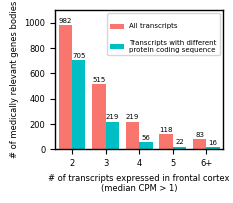

In [122]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_number_med_isoforms_per_gene, y="Number of gene bodies", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1, dodge=True)


labels = ["\nAll transcripts\n", "Transcripts with different\nprotein coding sequence"]
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, fontsize=5)
    
ax.set(ylim=(0, 1100), xlim=(-0.5, 4.5))
plt.ylabel("# of medically relevant genes bodies")
plt.xlabel("# of transcripts expressed in frontal cortex\n(median CPM > 1)")

ax.bar_label(ax.containers[0], fontsize=5, padding=1)
ax.bar_label(ax.containers[1], fontsize=5, padding=1)   


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/number_of_med_relevant_genes_with_multiple_transcripts_cpm_1.pdf', 
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [123]:
## Create CPM 1 Threhold multiple isoform filter
df_gene_brain = df_brain_relevant.loc[df_brain_relevant["median_CPM"] > 1].copy()
df_gene_mutiple_brain = df_gene_brain.loc[df_gene_brain.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_brain_multiple_isoforms_median = df_gene_mutiple_brain["gene_name"].value_counts()


## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_brain_multiple_iso = pd.DataFrame()
df_num_brain_multiple_iso["Number of gene bodies"] = df_numbers_brain_multiple_isoforms_median.value_counts()
df_num_brain_multiple_iso["Number of transcripts"] = df_numbers_brain_multiple_isoforms_median.value_counts().index
df_num_brain_multiple_iso["Category"] = "All transcripts"

## Group 7+ transcripts
df_num_brain_multiple_iso_six = df_num_brain_multiple_iso.loc[df_num_brain_multiple_iso["Number of transcripts"] >= 6].copy()
df_num_brain_multiple_iso_six = df_num_brain_multiple_iso_six.groupby("Category").sum()
df_num_brain_multiple_iso_six["Number of transcripts"] = "6+"
df_num_brain_multiple_iso_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_brain_multiple_iso = df_num_brain_multiple_iso.loc[df_num_brain_multiple_iso["Number of transcripts"] < 6].copy()
df_num_brain_multiple_iso["Number of transcripts"] = df_num_brain_multiple_iso["Number of transcripts"].astype(str)
df_num_brain_multiple_iso = pd.concat([df_num_brain_multiple_iso, df_num_brain_multiple_iso_six])

In [124]:
## Create CPM 1 Threhold multiple isoform filter
df_prot_coding_ccds = df_prot_coding_ccds.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")
df_prot_coding_ccds.drop_duplicates(inplace=True)
df_gene_mutiple_brain_prot = df_brain_relevant.loc[df_brain_relevant["median_CPM"] > 1].copy()


df_gene_mutiple_brain_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds['transcript_id'].isin(df_gene_mutiple_brain_prot["transcript_id"])].copy()                                                   

df_gene_mutiple_brain_prot = df_gene_mutiple_brain_prot.loc[~df_gene_mutiple_brain_prot.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_brain_prot = df_gene_mutiple_brain_prot.loc[df_gene_mutiple_brain_prot.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_brain_multiple_isoforms_prot_median = df_gene_mutiple_brain_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_brain = pd.DataFrame()
df_num_isoforms_prot_brain["Number of gene bodies"] = df_numbers_brain_multiple_isoforms_prot_median.value_counts()
df_num_isoforms_prot_brain["Number of transcripts"] = df_numbers_brain_multiple_isoforms_prot_median.value_counts().index
df_num_isoforms_prot_brain["Category"] = "Transcripts with different protein coding sequence"

## Group 7+ transcripts
df_num_isoforms_prot_brain_six = df_num_isoforms_prot_brain.loc[df_num_isoforms_prot_brain["Number of transcripts"] >= 6].copy()
df_num_isoforms_prot_brain_six = df_num_isoforms_prot_brain_six.groupby("Category").sum()
df_num_isoforms_prot_brain_six["Number of transcripts"] = "6+"
df_num_isoforms_prot_brain_six.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_prot_brain = df_num_isoforms_prot_brain.loc[df_num_isoforms_prot_brain["Number of transcripts"] < 6].copy()
df_num_isoforms_prot_brain["Number of transcripts"] = df_num_isoforms_prot_brain["Number of transcripts"].astype(str)
df_num_isoforms_prot_brain = pd.concat([df_num_isoforms_prot_brain, df_num_isoforms_prot_brain_six])

In [125]:
## Concatenate
df_number_brain_isoforms_per_gene = pd.concat([df_num_brain_multiple_iso, df_num_isoforms_prot_brain])

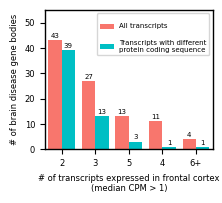

In [126]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_number_brain_isoforms_per_gene, y="Number of gene bodies", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1, dodge=True)


# replace labels   
labels = ["\nAll transcripts\n", "Transcripts with different\nprotein coding sequence"]
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, fontsize=5)

ax.set(ylim=(0, 55), xlim=(-0.5, 4.5))
plt.ylabel("# of brain disease gene bodies")
plt.xlabel("# of transcripts expressed in frontal cortex\n(median CPM > 1)")

ax.bar_label(ax.containers[0], fontsize=5, padding=1)
ax.bar_label(ax.containers[1], fontsize=5, padding=1)    


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/number_of_brain_genes_with_multiple_transcripts_cpm_1.pdf', dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [127]:
## Create disease panels
ad_panel = ["BIN1", "TNIP1", "APP", "ADAM17", "EED", "SHARPIN", "PSEN1", "ANK3", "MAPT", "BCKDK"]

pd_als_ftd_late_panel = ["SNCA", "ASXL3", "RIMS1", "GPNMB", "CLCN3", "SOD1", "VCP", "KIF5A", "TARDBP", "ABCC9"]

asd_sud_mdd_schizo = ["ANK2", "ARID1B", "SHANK3", "ADD1", "RHOA", "CTNND1", "MAOA", "PCLO", "CACNA1G", "GRIA3"]

In [128]:
## Create dataframe for AD panel
df_numbers_brain_multiple_iso = df_gene_mutiple_brain["gene_name"].value_counts().rename_axis('gene_name').reset_index(name='Number of transcripts')
df_numbers_brain_multiple_prot = df_gene_mutiple_brain_prot["gene_name"].value_counts().rename_axis('gene_name').reset_index(name='Number of transcripts')

df_numbers_ad_iso = df_numbers_brain_multiple_iso.loc[df_numbers_brain_multiple_iso["gene_name"].isin(ad_panel)].copy()
df_numbers_ad_prot = df_numbers_brain_multiple_prot.loc[df_numbers_brain_multiple_prot["gene_name"].isin(ad_panel)].copy()

df_numbers_ad_iso["Category"] = "All transcripts"
df_numbers_ad_prot["Category"] = "Transcripts with different protein coding sequence"

df_numbers_ad = pd.concat([df_numbers_ad_iso, df_numbers_ad_prot])

ad_psen = pd.DataFrame(data={"gene_name": ["PSEN1"], "Number of transcripts": [1], 
                              "Category": ["Transcripts with different protein coding sequence"]})

df_numbers_ad = pd.concat([df_numbers_ad, ad_psen])

In [129]:
## Create dataframe for PD + ALS/FTD + LATE panel
df_numbers_pd_iso = df_numbers_brain_multiple_iso.loc[df_numbers_brain_multiple_iso["gene_name"].isin(pd_als_ftd_late_panel)].copy()
df_numbers_pd_prot = df_numbers_brain_multiple_prot.loc[df_numbers_brain_multiple_prot["gene_name"].isin(pd_als_ftd_late_panel)].copy()

df_numbers_pd_iso["Category"] = "All transcripts"
df_numbers_pd_prot["Category"] = "Transcripts with different protein coding sequence"

df_numbers_pd = pd.concat([df_numbers_pd_iso, df_numbers_pd_prot])

pd_pink1 = pd.DataFrame(data={"gene_name": ["SNCA"], "Number of transcripts": [1], 
                              "Category": ["Transcripts with different protein coding sequence"]})

df_numbers_pd = pd.concat([df_numbers_pd, pd_pink1])

In [130]:
## Create dataframe for PD + ALS/FTD + LATE panel
df_numbers_asd_iso = df_numbers_brain_multiple_iso.loc[df_numbers_brain_multiple_iso["gene_name"].isin(asd_sud_mdd_schizo)].copy()
df_numbers_asd_prot = df_numbers_brain_multiple_prot.loc[df_numbers_brain_multiple_prot["gene_name"].isin(asd_sud_mdd_schizo)].copy()

df_numbers_asd_iso["Category"] = "All transcripts"
df_numbers_asd_prot["Category"] = "Transcripts with different protein coding sequence"

df_numbers_asd = pd.concat([df_numbers_asd_iso, df_numbers_asd_prot])

pd_maoa = pd.DataFrame(data={"gene_name": ["MAOA", "ANK2"], "Number of transcripts": [1, 1], 
                              "Category": ["Transcripts with different protein coding sequence", 
                                          "Transcripts with different protein coding sequence"]})

df_numbers_asd = pd.concat([df_numbers_asd, pd_maoa])

In [131]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (46*mm, 46*mm)
rcParams.update({'font.size': 6})
rcParams['axes.linewidth'] = 1

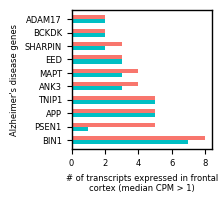

In [132]:
## Make AD panel
ax = sns.barplot(data=df_numbers_ad, y="gene_name", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[4], ggplot2_colors[0]], saturation=1, dodge=True,
                width=0.6, hue_order=["Transcripts with different protein coding sequence", "All transcripts"])

ax.set(ylim=(-0.7, 9.7))
ax.get_legend().remove()
plt.ylabel("Alzheimer's disease genes")
plt.xlabel("# of transcripts expressed in frontal\ncortex (median CPM > 1)")


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/alzheimers_genes_cpm_1.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

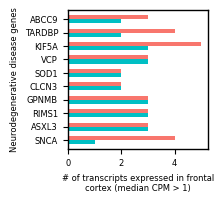

In [133]:
## Make PD + ALS/FTD + LATE panel
ax = sns.barplot(data=df_numbers_pd, y="gene_name", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[4], ggplot2_colors[0]], saturation=1, dodge=True,
                order=pd_als_ftd_late_panel, width=0.6,
                 hue_order=["Transcripts with different protein coding sequence", "All transcripts"])


ax.set(ylim=(-0.7, 9.7))
ax.get_legend().remove()
plt.ylabel("Neurodegenerative disease genes")
plt.xlabel("# of transcripts expressed in frontal\ncortex (median CPM > 1)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/neurodegenerative_genes_cpm_1.pdf', 
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

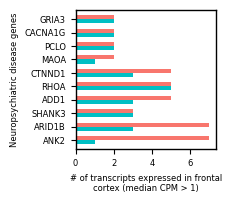

In [134]:
## Make PD + ALS/FTD + LATE panel
ax = sns.barplot(data=df_numbers_asd, y="gene_name", x="Number of transcripts",
                 hue="Category", palette=[ggplot2_colors[4], ggplot2_colors[0]], saturation=1, dodge=True,
                order=asd_sud_mdd_schizo, width=0.6, 
                hue_order=["Transcripts with different protein coding sequence", "All transcripts"])


ax.set(ylim=(-0.7, 9.7))
ax.get_legend().remove()
plt.ylabel("Neuropsychiatric disease genes")
plt.xlabel("# of transcripts expressed in frontal\ncortex (median CPM > 1)")


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/paper_figures/figure_5/neuropsychiatric_genes_cpm_1.pdf', dpi=600, transparent=True, bbox_inches="tight")

plt.show()

# Output novel high confidence only annotation

In [166]:
## Change mito columns names
df_novel_mito["gene_id"] = df_novel_mito["GENEID"].copy()
df_novel_mito["transcript_id"] = df_novel_mito["TXNAME"].copy()

In [167]:
## Merge all high confidence novel isoforms
df_all_novel = pd.concat([df_novel_mito, df_novel_genes_median, df_novel_transcripts_median])

In [168]:
## Open new Bambu reference
ref_novel = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

In [169]:
## Only keep novel transcripts
ref_novel = ref_novel.loc[ref_novel["other"].str.contains("transcript_id \"BambuTx")].copy()

In [170]:
## Parse through columns
ref_novel_high_confidence = parse_df_columns(ref_novel.copy(), is_ref=False, delete_other=False)

In [171]:
## Only keep high confidence transcripts
ref_novel_high_confidence = ref_novel_high_confidence.loc[ref_novel_high_confidence["transcript_id"].isin(df_all_novel["transcript_id"])].copy()

In [172]:
## Drop extraneous columns
ref_novel_high_confidence.drop(columns=["gene_id", "transcript_id", "exon_number"], inplace=True)

In [173]:
## Output new annotations

ref_novel.to_csv("../../../data/bernardo/processed/99.other/create_annotations/novel_only_annotations/all_novel_bambu.gtf", index=False, 
            header=False, sep="\t", quoting=csv.QUOTE_NONE)

ref_novel_high_confidence.to_csv("../../../data/bernardo/processed/99.other/create_annotations/novel_only_annotations/high_confidence_novel_bambu.gtf", index=False, 
            header=False, sep="\t", quoting=csv.QUOTE_NONE)

In [174]:
## Read flair annotation
glinos_annotation = pd.read_csv("../../../references/bernardo/flair_filter_transcripts.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

In [175]:
leung_annotation = pd.read_csv("../../../references/bernardo/HumanCTX.collapsed_classification.filtered_lite.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

In [176]:
glinos_annotation["chr"] = glinos_annotation["chr"].str.replace("chr", "").copy()
glinos_annotation["chr"] = glinos_annotation["chr"].str.replace("M", "MT").copy()


In [177]:
leung_annotation["chr"] = leung_annotation["chr"].str.replace("chr", "").copy()
leung_annotation["chr"] = leung_annotation["chr"].str.replace("M", "MT").copy()


In [178]:
glinos_annotation.to_csv("../../../data/bernardo/processed/99.other/create_annotations/novel_only_annotations/glinos_annotation_clean.gtf", index=False, 
            header=False, sep="\t", quoting=csv.QUOTE_NONE)

leung_annotation.to_csv("../../../data/bernardo/processed/99.other/create_annotations/novel_only_annotations/leung_annotation_clean.gtf", index=False, 
            header=False, sep="\t", quoting=csv.QUOTE_NONE)